In [1]:
#Importando a bilblioteca
import matplotlib.pyplot as plt
import gym
import time
import numpy as np
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import activations
from tensorflow.keras import regularizers
from tensorflow import constant
from tensorflow.keras.models import load_model

### Action Value Network
Criação da rede que irá mapear  **n entradas (quantidade de valores que descrevem um estado)** para **m saidas (action values - um para cada ação possível)**

In [2]:
class ActionValueNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        """
        Args:
            input_size (integer): The number of elements in the input of the network (Number of elements in the state).
            hidden_size (Tuple): The number of elements in the hidden layers.
            output_size (integer): The number of elements in the output (Number of possible actions).
        """
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        #Creates the model with the specified values
        self.model = Sequential()
        self.model.add(layers.Dense(hidden_size[0], input_dim=self.input_size, activation=activations.relu))
        for hidden in self.hidden_size[1:]:
            self.model.add(layers.Dense(hidden, activation=activations.relu))
        self.model.add(layers.Dense(self.output_size, activation=activations.linear))
        optimizer = optimizers.Adam(learning_rate=0.001, epsilon=1e-07)
        
        self.model.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])
    #--------------------------------------------------------------------------------
        
    def load(self, file_path):
        self.model = load_model(file_path)
        optimizer = optimizers.Adam(learning_rate=0.001)        
        self.model.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])
    #--------------------------------------------------------------------------------    
    
    def summary(self):
        self.model.summary()
    #-------------------------------------------------------------------------------- 
    
    def getActionValues(self, states):
        """
        Args:
            state (Numpy array): The states. (n, len(state))
        Returns:
            The action-values (Numpy array) calculated using the network's weights and softmax. (n, len(q_values))
        """
        q_values = self.model.predict(states)
        
        return q_values
    #-------------------------------------------------------------------------------- 
    
    def train(self, state, target_q):
        """
        Args:
            state (Numpy array): The states. (n, len(state))
            target_q (Numpy array): The target values of the q values (n, len(q_values))
        """
        self.model.fit(state, target_q, epochs=1, verbose=0)
    #--------------------------------------------------------------------------------    
    
    def softmax(self, q_values):
        """
        Args:
            q_values (Numpy array): The action values. (n, len(q_value))
        Returns:
            The "softmaxed" action values (n, len(q_value))
        """
        #q_values = q_values.reshape(1, 1, len(q_values))

        return activations.softmax(constant(q_values))
    #--------------------------------------------------------------------------------
    
    def save(self, file_path):
        self.model.save(file_path)
    #--------------------------------------------------------------------------------
        

In [3]:
"""
A = ActionValueNetwork(10, (5, 4), 4)
A.summary()
b = A.getActionValues(np.arange(200).reshape(20, 10))
print("--", np.shape(b))
c = np.arange(200).reshape(20, 10)
print(np.shape(c))
d = np.arange(80).reshape(20, 4)
print(np.shape(d))
A.train(c, d)
soft = A.softmax(b)
print(np.shape(soft))
print(soft[0], b[0])
"""

'\nA = ActionValueNetwork(10, (5, 4), 4)\nA.summary()\nb = A.getActionValues(np.arange(200).reshape(20, 10))\nprint("--", np.shape(b))\nc = np.arange(200).reshape(20, 10)\nprint(np.shape(c))\nd = np.arange(80).reshape(20, 4)\nprint(np.shape(d))\nA.train(c, d)\nsoft = A.softmax(b)\nprint(np.shape(soft))\nprint(soft[0], b[0])\n'

### Replay Buffer
Buffer que irá armazenar as experiencias do agente e recupera aleatoriamente uma quantidade definida dessas experiencias para que o agente treine com elas

In [4]:
class ReplayBuffer:
    def __init__(self, size, minibatch_size):
        """
        Args:
            size (integer): The size of the replay buffer.              
            minibatch_size (integer): The sample size.
        """
        self.buffer = []
        self.minibatch_size = minibatch_size
        self.rand_generator = np.random.RandomState()
        self.max_size = size
    #--------------------------------------------------------------------------------    

    def append(self, state, action, reward, terminal, next_state):
        """
        Args:
            state (Numpy array): The state.              
            action (integer): The action.
            reward (float): The reward.
            terminal (integer): 1 if the next state is a terminal state and 0 otherwise.
            next_state (Numpy array): The next state.           
        """
        if len(self.buffer) == self.max_size:
            del self.buffer[0]
        self.buffer.append([state, action, reward, terminal, next_state])
    #--------------------------------------------------------------------------------    

    def sample(self):
        """
        Returns:
            A list of transition tuples including state, action, reward, terminal, and next_state
        """
        idxs = self.rand_generator.choice(np.arange(len(self.buffer)), size=self.minibatch_size)
        return [self.buffer[idx] for idx in idxs]
    #--------------------------------------------------------------------------------    

    def size(self):
        """
        Returns:
            Number of elements in the buffer
        """
        return len(self.buffer)

### RL Agent
Agente que aprende os action values para cada ação  em cada estado de acordo com o método escolhido e escolhe a proxima ação de acordo com a policy escolhida

In [5]:
class RLAgent:
    def __init__(self, num_state,  num_hidden_units, num_actions, replay_buffer_size, minibatch_size
                 , discount=0.99, epsilon=0.1, egreedy=False, qlearning=True, epsilon_min=0.01, epsilon_decay=0.9996):
        self.num_state = num_state
        self.num_hidden_units = num_hidden_units
        self.num_actions = num_actions
        self.replay_buffer_size = replay_buffer_size
        self.minibatch_size = minibatch_size
        self.network = ActionValueNetwork(num_state, num_hidden_units, num_actions)
        self.replay_buffer = ReplayBuffer(replay_buffer_size, minibatch_size)
        self.discount = discount
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.egreedy = egreedy
        self.qlearning = qlearning
        self.rand_generator = np.random.RandomState()
    #--------------------------------------------------------------------------------    

    def policy(self, state, epsilon=None, egreedy=None):
        """
        The policy method that selects an action based on the action values
        Args:
            state (Numpy array): the state. (1, len(state))
        Returns:
            the action. 
        """
        if epsilon==None:
            epsilon = self.epsilon_min
        if egreedy==None:
            egreedy = self.egreedy
        state = state.reshape(1, len(np.squeeze(state)))
        action_values = self.network.getActionValues(state)
        
        #Value Probability
        if(egreedy==False):
            probs_batch = self.network.softmax(action_values)
            action = self.rand_generator.choice(self.num_actions, p=np.squeeze(probs_batch))
        
        #E-Greedy
        else:
            if np.random.rand() <= self.epsilon:
                action =  np.random.randint(self.num_actions)
            else:
                action = np.argmax(np.squeeze(action_values))
                
        return action
    #-------------------------------------------------------------------------------- 
    
    def getTargetValues(self, experiences):
        """
        Get the target values.
        Args:
            exp (list): [(last_state, last_action, reward, terminal, state), ...] (n, 5)
        Returns:
            The target action values for the state.
        """
        #last_state, last_action, reward, terminal, state = exp
        last_states = np.squeeze(np.array([elem[0] for elem in experiences])).reshape(len(experiences), len(experiences[0][0]))
        last_actions = np.squeeze(np.array([elem[1] for elem in experiences]))
        rewards = np.squeeze(np.array([elem[2] for elem in experiences]))
        terminals = np.squeeze(np.array([elem[3] for elem in experiences]))
        states = np.squeeze(np.array([elem[4] for elem in experiences])).reshape(len(experiences), len(experiences[0][4]))
        
        q_values = self.network.getActionValues(last_states) #(n, len(q_values))
        
        q_values_next = self.network.getActionValues(states) #(n, len(q_values))
        
        #Q-Learnig
        if(self.qlearning==True):
            targets = rewards + self.discount*(np.amax(q_values_next, axis=1))*(1-terminals)
            
        #Expected SARSA
        else:
            if(self.egreedy==False):
                targets = rewards + self.discount*(np.sum(self.network.softmax(q_values_next) * q_values_next, axis=1))*(1-terminals)
            else:
                probs = np.full(np.shape(q_values_next), self.epsilon/self.num_actions)
                probs[np.arange(len(experiences)), np.argmax(q_values_next, axis=1)] += (1 - self.epsilon)
                targets = rewards + self.discount*(np.sum(probs * q_values_next, axis=1))*(1-terminals)

        q_values[np.arange(len(experiences)), last_actions] = targets
        
        #q_values[last_action] = reward + self.discount*np.sum(np.array(self.network.softmax(q_values_next)).reshape(len(q_values_next), 1)*q_values_next)
        
        return q_values
    #-------------------------------------------------------------------------------- 

    def agentStart(self, state):
        """
        The first method called when the experiment starts, called after
        the environment starts.
        Args:
            state (Numpy array): the state from the environment's evn_start function.
        Returns:
            The first action the agent takes.
        """
        #state = state.reshape(1, len(state))
        self.sum_rewards = 0
        self.episode_steps = 0
        self.last_state = state
        self.last_action = self.policy(self.last_state, self.epsilon, self.egreedy)
        
        return self.last_action
    #--------------------------------------------------------------------------------    
   
    def agentStep(self, reward, state, terminal):
        """
        A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (Numpy array): the state from the environment's step based, where the agent ended up after the last step
            terminal (boolean): True if the agEnt is in the terminal state, False otherwise 
        Returns:
            The action the agent is taking.
        """
        if(terminal == True):
            terminal = 1
        else:
            terminal = 0
        
        #state = state.reshape(1, len(state))
        
        self.sum_rewards += reward
        self.episode_steps += 1

        action = self.policy(state, self.epsilon, self.egreedy)

        self.replay_buffer.append(self.last_state, self.last_action, reward, terminal, state)

        # Perform replay steps:
        if self.replay_buffer.size() > self.replay_buffer.minibatch_size:
            # Get sample experiences from the replay buffer
            experiences = self.replay_buffer.sample()
            
            #Get the state and target values for each state of the experiences
            exp_states = np.squeeze(np.array([elem[0] for elem in experiences])).reshape(len(experiences), len(experiences[0][0]))
            exp_target_values = self.getTargetValues(experiences)

            self.network.train(exp_states, exp_target_values)
        
        target = self.getTargetValues([[self.last_state, self.last_action, reward, terminal, state]])
        self.network.train(self.last_state.reshape(1, len(self.last_state)), target)
        
        #Decay the epsilon value
        if(self.epsilon > self.epsilon_min):
            self.epsilon *= self.epsilon_decay
        
        # Update the last state and last action.
        self.last_state = state
        self.last_action = action

        return action
    #--------------------------------------------------------------------------------    

    def agentEnd(self, reward):
        """
        Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the terminal state.
            terminal (boolean): True if the agEnt is in the terminal state, False otherwise
        Returns:
            The mean reward obtained in the episode
        """
        # Set terminal state to an array of zeros
        state = np.zeros_like(self.last_state)
            
        self.sum_rewards += reward
        self.episode_steps += 1

        # Append new experience to replay buffer
        self.replay_buffer.append(self.last_state, self.last_action, reward, 1, state)
        
        # Perform replay steps:
        if self.replay_buffer.size() > self.replay_buffer.minibatch_size:
             # Get sample experiences from the replay buffer
            experiences = self.replay_buffer.sample()
            
            #Get the state and target values for each state of the experiences
            exp_states = np.squeeze(np.array([elem[0] for elem in experiences])).reshape(len(experiences), len(experiences[0][0]))
            exp_target_values = self.getTargetValues(experiences)

            self.network.train(exp_states, exp_target_values)
        
        target = self.getTargetValues([[self.last_state, self.last_action, reward, 1, state]])
        self.network.train(self.last_state.reshape(1, len(self.last_state)), target)
            
        return [self.sum_rewards, self.episode_steps]
    #--------------------------------------------------------------------------------    
    
    def saveNet(self, file_path):
        self.network.save(file_path)
    #--------------------------------------------------------------------------------    
        
    def loadNet(self, file_path):
        self.network.load(file_path)

Rocket trajectory optimization is a classic topic in Optimal Control.

According to Pontryagin's maximum principle it's optimal to fire engine full throttle or
turn it off. That's the reason this environment is OK to have discreet actions (engine on or off).

The landing pad is always at coordinates (0,0). The coordinates are the first two numbers in the state vector.

Reward for moving from the top of the screen to the landing pad and zero speed is about 100..140 points.

If the lander moves away from the landing pad it loses reward. The episode finishes if the lander crashes or
comes to rest, receiving an additional -100 or +100 points. Each leg with ground contact is +10 points.

Firing the main engine is -0.3 points each frame. Firing the side engine is -0.03 points each frame.

Solved is 200 points.

Landing outside the landing pad is possible. Fuel is infinite, so an agent can learn to fly and then land
on its first attempt. Please see the source code for details.

In [6]:
env = gym.make('LunarLander-v2')
num_state = env.observation_space.shape[0]
num_actions = env.action_space.n
agent = RLAgent(num_state, [150, 80], num_actions, 100000, 30, egreedy=True, qlearning=True, epsilon_decay=1)
#agent.loadNet("/home/gustavo/PROG/RL_networks/MoonLander/8_150_80_4_eg_ql_LunarLander-v2.h5")
num_episodes = 350
verbose = 10
total_reward_per_episode = []
steps_per_episode = []

print("BEGIN\n")
compl = 0
for episode in range(num_episodes):
    steps = 0
    rewards = 0
    observation = env.reset()
    action = agent.agentStart(observation)
    terminal = False
    
    while(terminal == False): 
        #env.render()
        print("\r                                                                                         ", end="")
        print("\rEpisode: "+str(episode+1)+"\tStep: "+str(steps)+"\tReward: "+str(rewards), end="")
        observation, reward, terminal, info = env.step(action) 
        action = agent.agentStep(reward, observation, terminal)
        steps += 1
        rewards += reward
        
    total_reward, num_steps = agent.agentEnd(reward)
    total_reward_per_episode.append(total_reward) 
    steps_per_episode.append(num_steps)
    
    if(total_reward>200):
        compl+=1
        
    if((episode+1)%verbose == 0):
        print("\r                                                                                         ", end="")
        print("\rEpisodes: ", episode+1, "/", num_episodes
              , "\n\tTotal reward: ", np.mean(total_reward_per_episode[-verbose:])
              , "\n\tNum. steps: ", np.mean(steps_per_episode[-verbose:])
              , "\n\tCompleted: ", compl, "\n--------------------------\n")
        
        compl = 0
        
#env.close()        
print("\nFINISHED")
agent.saveNet("/home/gustavo/PROG/RL_networks/MoonLander/8_150_80_4_eg_ql_LunarLander-v2.h5")

/home/gustavo/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


BEGIN

Episodes:  10 / 350                                                                      
	Total reward:  -379.4862475420592 
	Num. steps:  202.5 
	Completed:  0 
--------------------------

Episodes:  20 / 350                                                                      
	Total reward:  -254.24287896618733 
	Num. steps:  215.5 
	Completed:  0 
--------------------------

Episodes:  30 / 350                                                                      
	Total reward:  -166.44598196008897 
	Num. steps:  299.6 
	Completed:  1 
--------------------------

Episodes:  40 / 350                                                                      
	Total reward:  -39.05056883877721 
	Num. steps:  785.0 
	Completed:  1 
--------------------------

Episodes:  50 / 350                                                                      
	Total reward:  -48.57604558609575 
	Num. steps:  841.4 
	Completed:  0 
--------------------------

Episodes:  60 / 350                 

In [11]:
#env = gym.make('LunarLander-v2')
#num_state = env.observation_space.shape[0]
#num_actions = env.action_space.n
#agent = RLAgent(num_state, [150], num_actions, 10000, 30, egreedy=False, qlearning=False)
#agent.loadNet("/home/gustavo/PROG/RL_networks/MoonLander/8_150_4_LunarLander-v2.h5")
observation = env.reset()
done = False
steps = 0
while(done == False):
    action = agent.policy(observation.reshape(1, len(observation)))
    env.render()
    observation, reward, done, info = env.step(action)
    steps += 1
env.close()


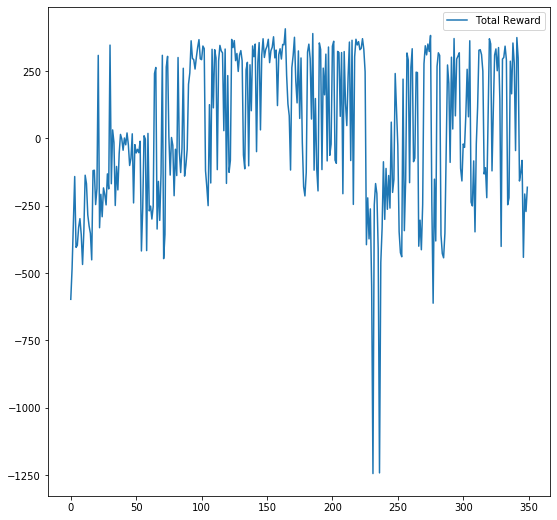

In [8]:
t = np.arange(num_episodes)
plt.figure(figsize=(9, 9))
plt.plot(t, total_reward_per_episode, label="Total Reward")
plt.legend()

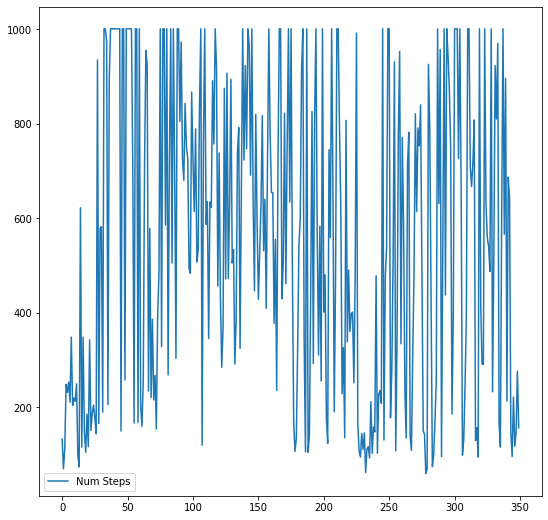

In [9]:
t = np.arange(num_episodes)
plt.figure(figsize=(9, 9))
plt.plot(t, steps_per_episode, label="Num Steps")
plt.legend()